### Initializations

Import third-party and built-in modules

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as scint
import pathlib

Import the fertilization module

In [2]:
from fertilization import *

Define folder for files output (adapt as needed)

In [3]:
base_dir = pathlib.Path(".").resolve()

Make sure that `.svg` exports have editable texts

In [4]:
old_fonttype = plt.rcParams['svg.fonttype']

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

## Multiple sperm groups

One group of eggs, diameter 120μm, initial concentration 50 eggs/mL, probability of fertilization given hit (fertilizability) = 0.1

_Note_ that cross sectional area $\sigma_0 = \pi r^2 = \pi (D/2)^2$

In [6]:
sigma0 = np.array([
    np.pi * (0.5 * 120E-6)**2,
])
alpha_const = 0.1
Einit = np.array([50E6])

In [7]:
def a_egg(t):
    return np.array([[alpha_const]])

Fertilization time: 1 hour = 60 minutes = 3600 seconds

In [8]:
t_end = 60 * 60 # = 60 minutes
t_array = np.arange(t_end / 4, t_end + 1, t_end / 4)

Concentration of sperms ranges logrithmically from 10 sperms per mL to 100000 sperms per mL

In [9]:
# 10**(1+6) to 10**(5+6)
Sinit_array = np.logspace(1 + 6, 5 + 6, (5 - 1) * 16 + 1, base=10)

Fast and furious dad: high constant speed of 200 μm/s, proportion motile decay exponentially from 0.8 to 0.4 over 1 hour

In [10]:
v_fast = 200E-6

SR_start = 0.8
SR_end = 0.4

SR_fast = SR_start
d_fast = -np.log(SR_end/SR_start) / t_end

In [11]:
print(d_fast)

0.0001925408834888737


Fast and furious dad: high constant speed of 200 μm/s, proportion motile decay exponentially from 0.8 to 0.4 over 1 hour

Slow and steady dad: proportion motile constant at 0.8, speed reduced to 144 μm/s

_Note_: speed is determined by the condition that the _expected distance travel_ equal between the two cases

In [12]:
d_slow = 0.0
SR_slow = 0.8

In [13]:
area_under = scint.quad(lambda t: SR_start * np.exp(-d_fast * t), 0, t_end)

In [14]:
v_slow = area_under[0] * v_fast / (SR_slow * t_end)

In [15]:
print(v_slow)

0.0001442695040888964


### Case (a): fast and furious ONLY

One group of sperms, speed = 200 μm/s, % motile = 0.8 exp decay to 0.4 @ 1 hour

In [16]:
def v_sperm_fast(t):
    return np.array([v_fast])

def d_sperm_fast(t):
    return np.array([d_fast])

Initialize arrays for $S_0$, $E_*$, and $S_\text{1,*}$

In [17]:
S0_array_fast = np.zeros([Sinit_array.size, t_array.size])
Eany_array_fast = np.zeros([Sinit_array.size, t_array.size])
S1a_array_fast = np.zeros([Sinit_array.size, t_array.size])

Loop through sperm concentration

_Note_ that `S_init` in the motile sperm concentration, so `_S` needs to be multiplied by `SR_fast`

In [18]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_fast, d_sperm_fast, np.array([_S * SR_fast]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_array_fast[_i, :] = model_S.S0(t_array)[0]
    Eany_array_fast[_i, :] = model_S.E_any(t_array)[0]
    S1a_array_fast[_i, :] = model_S.S_ord(t_array, 1)[0, 0]

Calculate proportion of free live sperms, fertilized eggs, and succeeding sperms

In [19]:
norm_S0_fast = S0_array_fast / Sinit_array[:, np.newaxis]
norm_Eany_fast = Eany_array_fast / Einit
norm_S1a_fast = S1a_array_fast / Einit

Plot proportion of eggs fertilized as function of sperm concentration (figure not saved)

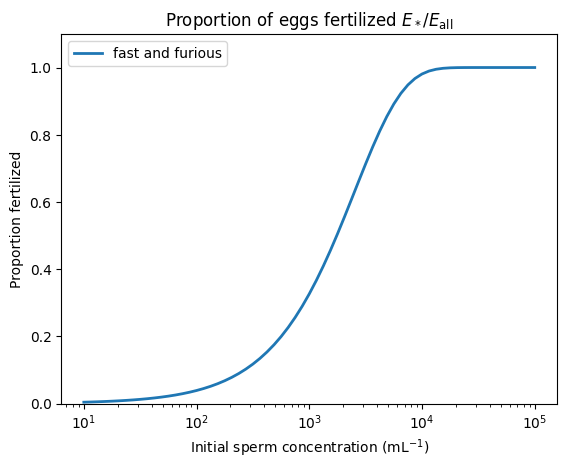

In [20]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_fast[:, -1], lw=2, 
    label="fast and furious"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left")

plt.show()

Plot proportion of free-live sperms as function of sperm concentration (figure not saved)

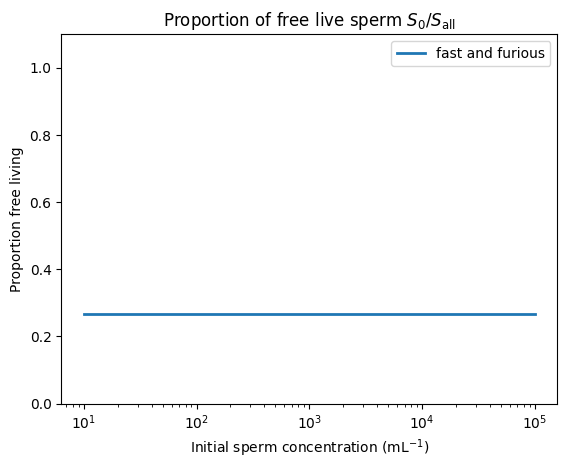

In [21]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_fast[:, -1], lw=2, 
    label="fast and furious"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")
plt.legend()

plt.show()

### Case (b): slow and steady dad ONLY

Two groups of sperms, speed = 144 μm/s, % motile = 0.8 constant

One group of sperms, speed = 144 μm/s, % motile = 0.8 constant

In [22]:
def v_sperm_slow(t):
    return np.array([v_slow])

def d_sperm_slow(t):
    return np.array([d_slow])

Initialize arrays, loop through concentration, etc.

In [23]:
S0_array_slow = np.zeros([Sinit_array.size, t_array.size])
Eany_array_slow = np.zeros([Sinit_array.size, t_array.size])
S1a_array_slow = np.zeros([Sinit_array.size, t_array.size])

In [24]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_slow, d_sperm_slow, np.array([_S * SR_slow]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_array_slow[_i, :] = model_S.S0(t_array)[0]
    Eany_array_slow[_i, :] = model_S.E_any(t_array)[0]
    S1a_array_slow[_i, :] = model_S.S_ord(t_array, 1)[0, 0]

In [25]:
norm_S0_slow = S0_array_slow / Sinit_array[:, np.newaxis]
norm_Eany_slow = Eany_array_slow / Einit
norm_S1a_slow = S1a_array_slow / Einit

Plot proportion of eggs fertilized as function of sperm concentration for the "fast and furious" and "slow and steady" cases, and save the resulting figure

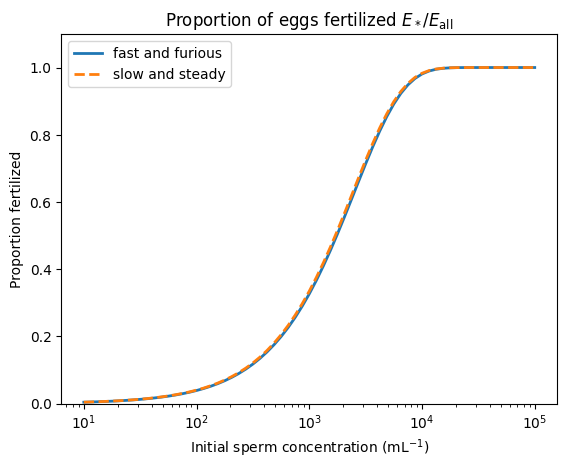

In [26]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_fast[:, -1], lw=2, 
    label="fast and furious"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_slow[:, -1], lw=2, ls="--",
    label="slow and steady"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend(loc="upper left")

plt.savefig(base_dir / 'prop_fert_fast_v_slow.svg')
plt.savefig(base_dir / 'prop_fert_fast_v_slow.pdf')

plt.show()

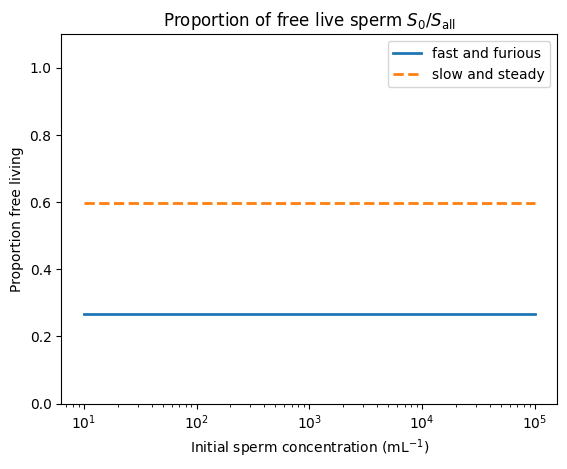

In [27]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_fast[:, -1], lw=2, 
    label="fast and furious"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_slow[:, -1], lw=2, ls="--",
    label="slow and steady"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")
plt.legend()

plt.show()

### Case (c): Mixture of both

Two groups of sperms of equal proportions. First group with speed = 200 μm/s and % motile = 0.8 exp decay to 0.4 @ 1 hour; second group with speed  = 144 μm/s and proportion motile = 0.8 constant

Note that sperm speed (`v_sperm_mix`) and sperm decay rate (`d_sperm_mix`) are now a 2-dim vectors, while fertilizability (`a_egg_mix`) is now a 2-by-1 matrix.

In [28]:
def v_sperm_mix(t):
    return np.array([v_fast, v_slow])

def d_sperm_mix(t):
    return np.array([d_fast, d_slow])

In [29]:
def a_egg_mix(t):
    return np.array([[alpha_const], [alpha_const]])

In [30]:
Eany_array_mx = np.zeros([Sinit_array.size, t_array.size])
S0_array_mx_fast = np.zeros([Sinit_array.size, t_array.size])
S0_array_mx_slow = np.zeros([Sinit_array.size, t_array.size])
S1a_array_mx_fast = np.zeros([Sinit_array.size, t_array.size])
S1a_array_mx_slow = np.zeros([Sinit_array.size, t_array.size])

_Note_ that the array of concentration correponds total concentration (i.e., sum of "fast and furious" and "slow and steady" group), hence an additional factor of 0.5 in the `S_init` argument.

In [31]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm_mix, d_sperm_mix, 
        np.array([0.5 * _S * SR_fast, 0.5 * _S * SR_slow]),
        a_egg_mix, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    _tmp = model_S.S0(t_array)
    S0_array_mx_fast[_i, :] = _tmp[0]
    S0_array_mx_slow[_i, :] = _tmp[1]
    Eany_array_mx[_i, :] = model_S.E_any(t_array)[0]
    _tmp = model_S.S_ord(t_array, 1)[:, 0]
    S1a_array_mx_fast[_i, :] = _tmp[0]
    S1a_array_mx_slow[_i, :] = _tmp[1]

In [32]:
norm_Eany_mx = Eany_array_mx / Einit
norm_S0_mx_fast = S0_array_mx_fast / (0.5 * Sinit_array[:, np.newaxis])
norm_S0_mx_slow = S0_array_mx_slow / (0.5 * Sinit_array[:, np.newaxis])
norm_S1a_mx_fast = S1a_array_mx_fast / Einit
norm_S1a_mx_slow = S1a_array_mx_slow / Einit

Sanity check: $\sum S_{1,*}$ should always equal to $E_*$, i.e., the two curves should overlap perfectly.

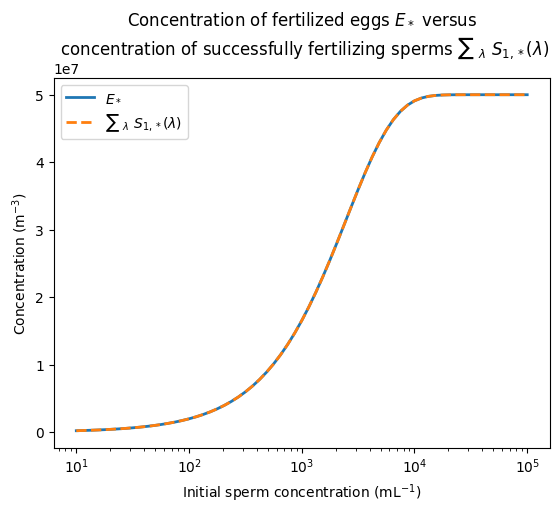

In [33]:
plt.plot(
    1E-6 * Sinit_array, Eany_array_mx[:, -1], lw=2, 
    label="$E_*$"
)
plt.plot(
    1E-6 * Sinit_array, S1a_array_mx_fast[:, -1] + S1a_array_mx_slow[:, -1], 
    lw=2, ls="--",
    label="$\\sum$ $_\\lambda$ $S_{1,*}(\\lambda)$"
)

title_text = ("Concentration of fertilized eggs $E_*$" + 
    " versus\n concentration of successfully fertilizing sperms" + 
    " $\\sum$ $_\\lambda$ $S_{1,*}(\\lambda)$"
)
plt.title(title_text)

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Concentration (m$^{-3}$)")
plt.legend()

plt.show()

Plot of comparison in the proportion of eggs fertilized between the "fast", "slow", and mixed cases, and save the resulting figure

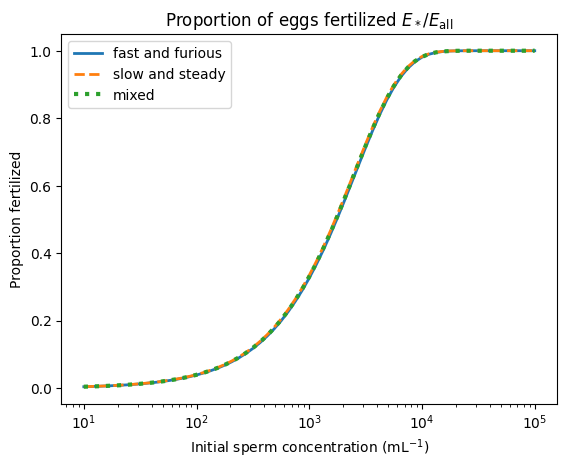

In [34]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_fast[:, -1], lw=2, 
    label="fast and furious"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_slow[:, -1], lw=2, ls="--",
    label="slow and steady"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_mx[:, -1], lw=3, ls=":",
    label="mixed"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.savefig(base_dir / 'prop_fert_mixed.svg')
plt.savefig(base_dir / 'prop_fert_mixed.pdf')

plt.show()

Plot the proportion of eggs fertilized by specific sperm group in the mixed case, and save the resulting figure

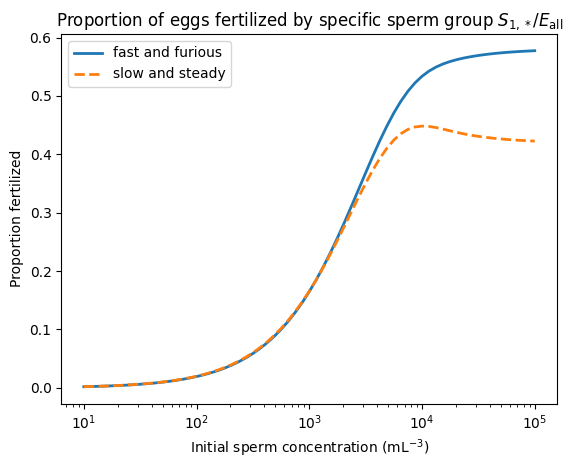

In [35]:
plt.plot(
    1E-6 * Sinit_array, norm_S1a_mx_fast[:, -1], lw=2, 
    label="fast and furious"
)
plt.plot(
    1E-6 * Sinit_array, norm_S1a_mx_slow[:, -1], lw=2, ls="--",
    label="slow and steady"
)

plt.title(
    "Proportion of eggs fertilized by specific sperm group" + 
    " $S_{1,*} / E_\\text{all}$"
)

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-3}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.savefig(base_dir / 'prop_fert_by_sperm.svg')
plt.savefig(base_dir / 'prop_fert_by_sperm.pdf')

plt.show()

Plot the proportion of free live sperm for both sperm groups in the mixed case

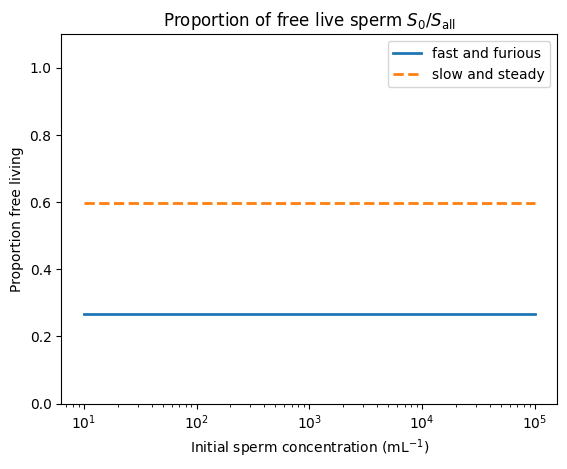

In [36]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_mx_fast[:, -1], lw=2, 
    label="fast and furious"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_mx_slow[:, -1], lw=2, ls="--",
    label="slow and steady"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")
plt.legend()

plt.show()

## Saving results

Construct the correct sperm concentration and time point labels for serialized numpy arrays

In [37]:
S_grid, t_grid = np.meshgrid(
    Sinit_array, t_array, indexing='ij'
)

Construct dataframes for each of the three cases

In [38]:
df_fast = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_fast.ravel(),
    "E_* prop": norm_Eany_fast.ravel(),
    "S_{1,*} prop": norm_S1a_fast.ravel(),
})
df_slow = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 prop": norm_S0_slow.ravel(),
    "E_* prop": norm_Eany_slow.ravel(),
    "S_{1,*} prop": norm_S1a_slow.ravel(),
})
df_mixed = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "S0 fast prop": norm_S0_mx_fast.ravel(),
    "S0 slow prop": norm_S0_mx_slow.ravel(),
    "E_* prop": norm_Eany_mx.ravel(),
    "S_{1,*} fast prop": norm_S1a_mx_fast.ravel(),
    "S_{1,*} slow prop": norm_S1a_mx_slow.ravel(),
})

Write to Excel (with each dataframe a separate sheet)

In [39]:
with pd.ExcelWriter('multiple_sperms.xlsx', mode='w') as writer:  
    df_fast.to_excel(writer, sheet_name='fast', index=False)
    df_slow.to_excel(writer, sheet_name='slow', index=False)
    df_mixed.to_excel(writer, sheet_name='mixed', index=False)

Record the relevant parameters used and save to file

In [40]:
param_str = f'''
sigma0 = {sigma0.item()}
alpha = {alpha_const}
Einit = {Einit.item()}

t_end = {t_end}

v_sperm_fast = {v_fast}
d_sperm_fast = {d_fast}
SR_fast = {SR_fast}

v_sperm_slow = {v_slow}
d_sperm_slow = {d_slow}
SR_slow = {SR_slow}
'''

In [41]:
with open(base_dir / "multi_sperms_params.txt", "w") as outfile:
    outfile.write(param_str)